#  Import required packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
import os
from datetime import datetime

# Load and Preprocess data

In [3]:
# Load Fashion MNIST dataset directly from Keras
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the pixel values to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Add a channel dimension (for grayscale images)
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Define the VAE model components

In [7]:
# Sampling function to get the latent vector Z from the mean and log variance
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder model
latent_dim = 2  # Latent space dimensions (for visualization in 2D)
encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder model
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

# VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Compute the KL divergence and reconstruction loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, reconstructed)) * 28 * 28
        
        # Combine losses
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        return reconstructed

# Instantiate the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# Set up TensorBoard callback
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train the VAE model

In [10]:
vae.fit(train_images, train_images, epochs=20, batch_size=128, validation_data=(test_images, test_images), callbacks=[tensorboard_callback])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 126ms/step - loss: 48701.8672 - val_loss: 36725.2734
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - loss: 36258.9844 - val_loss: 35716.9570
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - loss: 35467.8281 - val_loss: 35219.9180
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 156ms/step - loss: 34981.3516 - val_loss: 34994.8555
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 170ms/step - loss: 34776.7344 - val_loss: 34960.2031
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 182ms/step - loss: 34664.1406 - val_loss: 34779.7422
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 181ms/step - loss: 34519.3672 - val_loss: 34745.4297
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 247ms/step - loss: 34395.6211 - val_loss: 34533.3555
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 158s 281ms/step - loss: 34409.4648 - val_loss: 34574.5156
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 158ms/step - loss: 34253.2383 - val_loss: 34673.8984
Epoch 11/20
469/469 ━━━━━━━

# Visualize latent space (Z variables) using TensorBoard Projector

In [12]:
# Generate latent variables for the test images
z_mean, _, _ = vae.encoder.predict(test_images)

# Use TensorBoard to visualize the latent space
os.makedirs('vae_logs', exist_ok=True)
with open(os.path.join('vae_logs', 'metadata.tsv'), 'w') as f:
    f.write("Class\n")
    for label in test_labels:
        f.write(f"{label}\n")

# Save the latent variables
np.savetxt(os.path.join('vae_logs', 'latent_vars.tsv'), z_mean)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


# Visualize in TensorBoard:

In [15]:
!pip install tensorboard

%load_ext tensorboard
%tensorboard --logdir logs/fit


# Visualize original and reconstructed images for two images from each class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


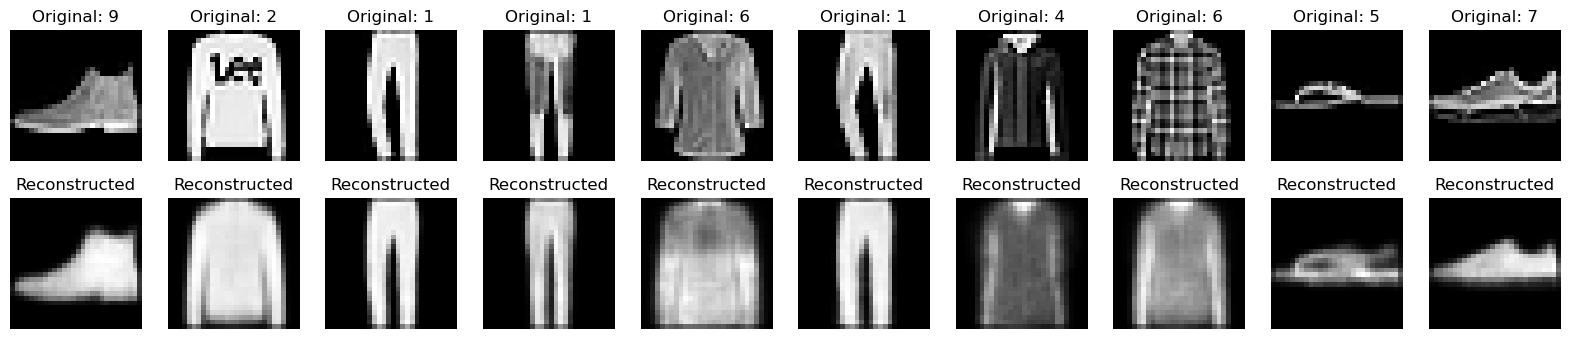

In [17]:
n = 10  # Number of images per class
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Original: {test_labels[i]}")
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_img = vae.decoder.predict(np.expand_dims(z_mean[i], axis=0))
    plt.imshow(reconstructed_img.reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()